In [15]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
import warnings
warnings.filterwarnings('ignore')

import kagglehub

download_path = "./input.csv"

# Download latest version
path = kagglehub.dataset_download("abhilashjash/covid-19-simulated-dataset-by-abhilash-jash")

print("Path to dataset files:", path)

data_csv_location = download_path
target_col = "Is_Covid_True"

Path to dataset files: C:\Users\akoni\.cache\kagglehub\datasets\abhilashjash\covid-19-simulated-dataset-by-abhilash-jash\versions\1


In [16]:
data = pd.read_csv(data_csv_location)

# Display the first 2 rows of the dataset to get a quick look at the data
data.head(2)

# Generate summary statistics for numerical columns (count, mean, std, min, quartiles, max)
data.describe()

# Print concise information about the DataFrame: column names, non-null counts, and data types
data.info()

# Count the number of missing (NaN) values in each column
data.isnull().sum()

# Display the list of all column names in the dataset
#data.columns
#data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 30 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Patient_ID             1000000 non-null  int64  
 1   Name                   1000000 non-null  object 
 2   Age                    950121 non-null   float64
 3   Gender                 989925 non-null   object 
 4   Blood_Pressure         919632 non-null   float64
 5   Heart_Rate             919474 non-null   float64
 6   Fever                  979957 non-null   object 
 7   Cough                  979942 non-null   object 
 8   Sore_Throat            979981 non-null   object 
 9   Fatigue                980167 non-null   object 
 10  Headache               980219 non-null   object 
 11  Breathlessness         979936 non-null   object 
 12  Loss_of_Smell_Taste    980051 non-null   object 
 13  Diarrhea               980137 non-null   object 
 14  Chest_Pain         

Patient_ID                   0
Name                         0
Age                      49879
Gender                   10075
Blood_Pressure           80368
Heart_Rate               80526
Fever                    20043
Cough                    20058
Sore_Throat              20019
Fatigue                  19833
Headache                 19781
Breathlessness           20064
Loss_of_Smell_Taste      19949
Diarrhea                 19863
Chest_Pain               19961
Body_Ache                19815
Runny_Nose               20164
Vomiting                 20045
Diabetes                 20073
Hypertension             19868
Asthma                   19939
Obesity                  20228
Smoking                  20212
Vaccinated               19889
Travel_History           20328
Contact_with_Positive    19955
Comorbidity_Count        49934
ICU_Admission            20153
Hospitalization_Days     80119
Is_Covid_True             9987
dtype: int64

In [17]:
data.dropna(inplace=True)
data = data.replace(False, 0)
data = data.replace(True, 1)

print(data)

data["Is_Male"] = (data["Gender"] == "Male").astype(int)
data["Is_Female"] = (data["Gender"] == "Female").astype(int)
data["Gender_Other"] = (data["Gender"] == "Other").astype(int)

data = data.drop(["Patient_ID", "Gender", "Name"], axis=1)

# Display the first 2 rows of the dataset to get a quick look at the data
data.head(2)

# Generate summary statistics for numerical columns (count, mean, std, min, quartiles, max)
data.describe()
data.describe().to_csv('./health-dashboard/public/metadata.csv')

# Print concise information about the DataFrame: column names, non-null counts, and data types
data.info()



        Patient_ID             Name   Age  Gender  Blood_Pressure  Heart_Rate  \
1                2         Joe Case  93.0   Other           118.0        66.0   
2                3     Melissa Dean  15.0   Other           153.0        79.0   
4                5        Tina Hill  61.0    Male           145.0        93.0   
8                9   James Campbell  75.0    Male           129.0        70.0   
9               10  Alexander Stark  75.0   Other           127.0        74.0   
...            ...              ...   ...     ...             ...         ...   
999993      999994    Ricky Daniels  17.0  Female           142.0       114.0   
999995      999996   Melody Wallace  85.0  Female           132.0        89.0   
999996      999997     Arthur Stone  54.0   Other           147.0        77.0   
999997      999998  Katherine Klein  70.0    Male           117.0        71.0   
999999     1000000    Logan Osborne  23.0  Female           130.0       114.0   

        Fever  Cough  Sore_

In [18]:
# Count the number of missing (NaN) values in each column
data.isnull().sum()

# Display the list of all column names in the dataset
data

,Age,Blood_Pressure,Heart_Rate,Fever,Cough,Sore_Throat,Fatigue,Headache,Breathlessness,Loss_of_Smell_Taste,...,Vaccinated,Travel_History,Contact_with_Positive,Comorbidity_Count,ICU_Admission,Hospitalization_Days,Is_Covid_True,Is_Male,Is_Female,Gender_Other
1,93.0,118.0,66.0,0,0,0,0,1,0,1,...,1,0,1,0.0,0,7.0,1,0,0,1
2,15.0,153.0,79.0,0,0,0,0,1,1,0,...,1,0,0,4.0,0,22.0,1,0,0,1
4,61.0,145.0,93.0,0,0,0,0,0,0,0,...,0,0,0,2.0,0,14.0,0,1,0,0
8,75.0,129.0,70.0,0,1,0,1,0,0,1,...,1,0,0,0.0,0,25.0,1,1,0,0
9,75.0,127.0,74.0,0,0,0,0,0,0,0,...,1,0,0,3.0,0,13.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999993,17.0,142.0,114.0,1,0,1,1,0,0,0,...,1,0,0,1.0,0,0.0,1,0,1,0
999995,85.0,132.0,89.0,0,0,0,1,0,0,0,...,0,0,0,0.0,0,29.0,0,0,1,0
999996,54.0,147.0,77.0,0,0,1,0,0,0,1,...,1,0,0,3.0,0,15.0,1,0,0,1
999997,70.0,117.0,71.0,0,0,1,1,0,0,0,...,1,0,0,4.0,0,14.0,0,1,0,0


In [19]:
data.isnull().sum()

Age                      0
Blood_Pressure           0
Heart_Rate               0
Fever                    0
Cough                    0
Sore_Throat              0
Fatigue                  0
Headache                 0
Breathlessness           0
Loss_of_Smell_Taste      0
Diarrhea                 0
Chest_Pain               0
Body_Ache                0
Runny_Nose               0
Vomiting                 0
Diabetes                 0
Hypertension             0
Asthma                   0
Obesity                  0
Smoking                  0
Vaccinated               0
Travel_History           0
Contact_with_Positive    0
Comorbidity_Count        0
ICU_Admission            0
Hospitalization_Days     0
Is_Covid_True            0
Is_Male                  0
Is_Female                0
Gender_Other             0
dtype: int64

In [20]:
# covid positive by blood pressure

bp_data = data[["Blood_Pressure", "Is_Covid_True"]]
bp_data.sort_values(by=["Blood_Pressure"], ascending=False, inplace=True)
bp_data

,Blood_Pressure,Is_Covid_True
427928,179.0,1
428152,179.0,0
506010,179.0,1
505952,179.0,1
182704,179.0,1
...,...,...
552146,80.0,1
35202,80.0,0
89,80.0,1
831240,80.0,0


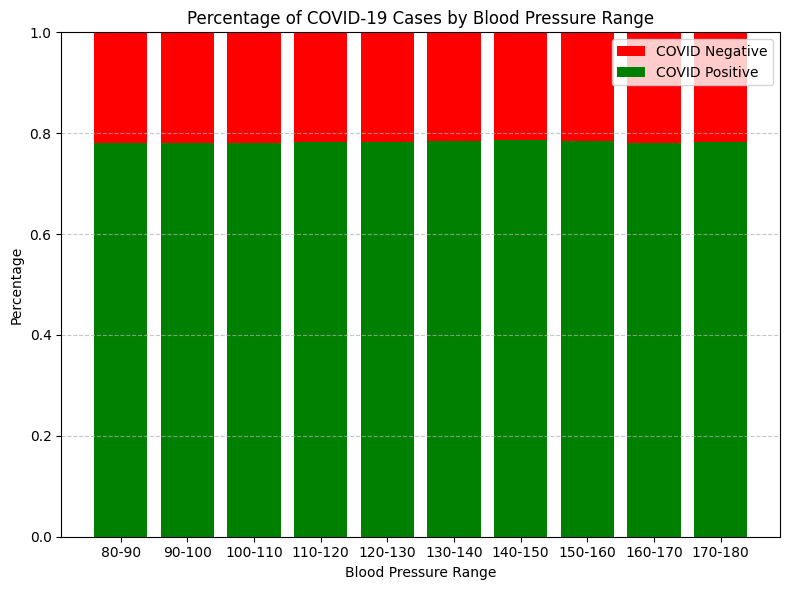

bp_range
80-90      0.780419
90-100     0.781078
100-110    0.781124
110-120    0.782558
120-130    0.782345
130-140    0.783787
140-150    0.786129
150-160    0.784328
160-170    0.781075
170-180    0.782408
Name: count, dtype: float64


In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Define blood pressure bins and labels
min_blood_pressure = 80
max_blood_pressure = 180
step = 10
blood_pressure_ranges = range(min_blood_pressure, max_blood_pressure + step, step)
blood_pressure_labels = [f'{i}-{i+step}' for i in blood_pressure_ranges[:-1]]

# Bin the data
bp_data['bp_range'] = pd.cut(
    bp_data['Blood_Pressure'],
    bins=blood_pressure_ranges,
    labels=blood_pressure_labels,
    right=False
)

# Count total, positive, and negative entries
total_counts = bp_data['bp_range'].value_counts().sort_index()
positive_counts = bp_data[bp_data['Is_Covid_True'] == 1]['bp_range'].value_counts().sort_index()
negative_counts = total_counts - positive_counts

# Reindex to include all bins
total_counts = total_counts.reindex(blood_pressure_labels, fill_value=0)
positive_counts = positive_counts.reindex(blood_pressure_labels, fill_value=0)
negative_counts = negative_counts.reindex(blood_pressure_labels, fill_value=0)

# Avoid division by zero (e.g., empty bins)
positive_percent = (positive_counts / total_counts).fillna(0)
negative_percent = (negative_counts / total_counts).fillna(0)

# Plot 100% stacked bar chart
plt.figure(figsize=(8, 6))
plt.bar(blood_pressure_labels, negative_percent, bottom=positive_percent, label='COVID Negative', color='red')
plt.bar(blood_pressure_labels, positive_percent, label='COVID Positive', color='green')


plt.title("Percentage of COVID-19 Cases by Blood Pressure Range")
plt.xlabel("Blood Pressure Range")
plt.ylabel("Percentage")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# blood pressure isn't a useful metric
print(positive_percent) # 78.xx% for all BP ranges


In [22]:
import json, math
from datetime import datetime
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    confusion_matrix, precision_score, recall_score, f1_score
)

# Helper to make JSON-safe
def to_py(o):
    if isinstance(o, np.generic):
        return o.item()
    if isinstance(o, np.ndarray):
        return o.tolist()
    if isinstance(o, dict):
        return {str(k): to_py(v) for k, v in o.items()}
    if isinstance(o, (list, tuple)):
        return [to_py(v) for v in o]
    return o

# 1. Load data
df = data

print(df[target_col])

y = df[target_col].astype(int).values
X = df.drop(columns=[target_col])

# Split categorical vs numeric
categorical_cols, numeric_cols = [], []
for c in X.columns:
    if X[c].dtype == "object":
        categorical_cols.append(c)
    elif pd.api.types.is_integer_dtype(X[c]):
        (categorical_cols if X[c].nunique() <= 10 else numeric_cols).append(c)
    else:
        numeric_cols.append(c)

# 2. Split train/test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Preprocessing
numeric_transformer = Pipeline([("imputer", SimpleImputer(strategy="median"))])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# 4. Decision Tree with hyperparameter search
dt = DecisionTreeClassifier(random_state=42)

pipe = Pipeline([
    ("pre", preprocessor),
    ("dt", dt)
])

param_grid = {
    "dt__max_depth": [3, 4, 5, 6, None],
    "dt__min_samples_leaf": [1, 2, 5, 10]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe, param_grid, cv=cv,
    scoring="f1", n_jobs=-1
)
grid.fit(X_trainval, y_trainval)

best_pipe = grid.best_estimator_
best_params = grid.best_params_

# 5. Choose threshold (favor recall on val set)
val_proba = best_pipe.predict_proba(X_trainval)[:, 1]
prec, rec, thr = precision_recall_curve(y_trainval, val_proba)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
mask = rec >= 0.85
if mask.any():
    idx = np.nanargmax(f1s[mask])
    chosen_threshold = thr[max(0, np.where(mask)[0][idx] - 1)]
else:
    chosen_threshold = thr[np.nanargmax(f1s)] if len(thr) > 0 else 0.5
chosen_threshold = float(chosen_threshold)

# 6. Evaluate on test
test_proba = best_pipe.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= chosen_threshold).astype(int)

metrics = {
    "roc_auc": float(roc_auc_score(y_test, test_proba)),
    "pr_auc": float(average_precision_score(y_test, test_proba)),
    "precision": float(precision_score(y_test, test_pred)),
    "recall": float(recall_score(y_test, test_pred)),
    "f1": float(f1_score(y_test, test_pred))
}
tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()
metrics["specificity"] = float(tn / (tn + fp + 1e-12))
metrics["confusion_matrix"] = {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)}

# 7. Export preprocessing manifest
preprocessor.fit(X_trainval)

# Handle numeric imputation values and ranges safely
if numeric_cols:
    num_imputer = preprocessor.named_transformers_["num"].named_steps["imputer"]
    num_impute_values = {
        c: float(v)
        for c, v in zip(numeric_cols, num_imputer.statistics_.tolist())
    }
    num_ranges = {
        c: {"min": float(X_trainval[c].min()), "max": float(X_trainval[c].max())}
        for c in numeric_cols
    }
else:
    num_impute_values = {}
    num_ranges = {}

onehot = preprocessor.named_transformers_["cat"].named_steps["onehot"]
cat_vocabs = {}
for c, cats in zip(categorical_cols, onehot.categories_):
    cat_vocabs[c] = [None if (isinstance(v, float) and math.isnan(v)) else v for v in cats.tolist()]

final_feature_order = []
for col in numeric_cols:
    final_feature_order.append({"source": col, "kind": "numeric"})
for col, cats in cat_vocabs.items():
    for cat in cats:
        final_feature_order.append({"source": col, "kind": "onehot", "category": cat})

preproc_manifest = {
    "numeric": numeric_cols,
    "categorical": categorical_cols,
    "numeric_imputation": num_impute_values,
    "numeric_ranges_train": num_ranges,
    "categorical_vocabulary": cat_vocabs,
    "final_feature_order": final_feature_order,
    "preproc_version": "v1",
    "trained_on": datetime.utcnow().strftime("%Y-%m-%d")
}


# 8. Export Decision Tree structure
def export_tree(tree_estimator):
    tree = tree_estimator.tree_
    nodes = []
    for i in range(tree.node_count):
        nodes.append({
            "feature_index": int(tree.feature[i]),
            "threshold": float(tree.threshold[i]),
            "left": int(tree.children_left[i]),
            "right": int(tree.children_right[i]),
            "value": [float(x) for x in tree.value[i][0].tolist()],
            "is_leaf": bool(tree.children_left[i] == -1 and tree.children_right[i] == -1),
        })
    return {"nodes": nodes}

dt_est = best_pipe.named_steps["dt"]
dt_export = {
    "params": best_params,
    "threshold": chosen_threshold,
    "metrics": metrics,
    "model_version": "v1",
    "trained_on": datetime.utcnow().strftime("%Y-%m-%d"),
    "tree": export_tree(dt_est)
}

# 9. Model Card
model_card = f"""# Heart Disease Decision Tree Model Card

**Model version:** v1  
**Training date:** {datetime.utcnow().strftime("%Y-%m-%d")}  

### Best Params
{best_params}

### Metrics (Test Set)
{json.dumps(metrics, indent=2)}

### Notes
Educational demo only — not medical advice.
"""

# 10. Golden Examples
golden = []
for i in range(min(10, len(X_test))):
    row = X_test.iloc[i].to_dict()
    golden.append({
        "input": to_py(row),
        "pred_proba_high": float(test_proba[i]),
        "label": int(test_pred[i]),
        "true": int(y_test[i])
    })

# 11. Save artifacts
with open("preproc_v1.json","w") as f: json.dump(to_py(preproc_manifest),f,indent=2)
with open("dt_model_v1.json","w") as f: json.dump(to_py(dt_export),f,indent=2)
with open("model_card_v1.md","w") as f: f.write(model_card)
with open("golden_examples_v1.json","w") as f: json.dump(to_py(golden),f,indent=2)

print("Artifacts written: preproc_v1.json, dt_model_v1.json, model_card_v1.md, golden_examples_v1.json")


1         1
2         1
4         0
8         1
9         0
         ..
999993    1
999995    0
999996    1
999997    0
999999    1
Name: Is_Covid_True, Length: 449882, dtype: int64
Artifacts written: preproc_v1.json, dt_model_v1.json, model_card_v1.md, golden_examples_v1.json


In [23]:
import json
import numpy as np

class DecisionTreePredictor:
    def __init__(self, preproc_path="preproc_v1.json", model_path="dt_model_v1.json"):
        """Initialize the predictor with preprocessing and model configs"""
        with open(preproc_path, 'r') as f:
            self.preproc = json.load(f)
        with open(model_path, 'r') as f:
            self.model = json.load(f)
        
        self.tree = self.model['tree']['nodes']
        self.threshold = self.model['threshold']
        
    def get_user_input(self):
        """Collect user input for all features"""
        print("\n=== Heart Disease Risk Assessment ===")
        print("Please enter the following information:\n")
        
        user_data = {}
        
        # Collect numeric features
        for col in self.preproc['numeric']:
            range_info = self.preproc['numeric_ranges_train'][col]
            while True:
                try:
                    value = input(f"{col} (typical range: {range_info['min']:.1f}-{range_info['max']:.1f}): ").strip()
                    if value == "":
                        # Use imputation value if empty
                        user_data[col] = None
                        print(f"  → Using median value: {self.preproc['numeric_imputation'][col]:.1f}")
                        break
                    else:
                        user_data[col] = float(value)
                        break
                except ValueError:
                    print("  Please enter a valid number or press Enter to use default")
        
        # Collect categorical features
        for col in self.preproc['categorical']:
            vocab = self.preproc['categorical_vocabulary'][col]
            print(f"\n{col} options: {', '.join(str(v) for v in vocab if v is not None)}")
            while True:
                value = input(f"{col}: ").strip()
                if value == "":
                    user_data[col] = None
                    print(f"  → Using most frequent value")
                    break
                # Try to convert to appropriate type
                try:
                    if value.isdigit():
                        value = int(value)
                    user_data[col] = value
                    break
                except:
                    user_data[col] = value
                    break
        
        return user_data
    
    def preprocess_input(self, user_data):
        """Apply preprocessing to user input"""
        features = []
        
        # Process numeric features
        for col in self.preproc['numeric']:
            value = user_data.get(col)
            if value is None:
                # Apply imputation
                value = self.preproc['numeric_imputation'][col]
            features.append(value)
        
        # Process categorical features with one-hot encoding
        for col in self.preproc['categorical']:
            value = user_data.get(col)
            vocab = self.preproc['categorical_vocabulary'][col]
            
            # Create one-hot encoding
            for category in vocab:
                if value == category:
                    features.append(1.0)
                else:
                    features.append(0.0)
        
        return np.array(features)
    
    def trace_tree(self, features):
        """Trace through the decision tree and return path"""
        path = []
        node_idx = 0  # Start at root
        
        while True:
            node = self.tree[node_idx]
            
            if node['is_leaf']:
                # Reached a leaf node
                path.append({
                    'node': node_idx,
                    'type': 'leaf',
                    'values': node['value']
                })
                break
            
            # Get feature name for this split
            feature_idx = node['feature_index']
            feature_info = self.preproc['final_feature_order'][feature_idx]
            
            # Make decision
            feature_value = features[feature_idx]
            threshold = node['threshold']
            
            if feature_value <= threshold:
                next_node = node['left']
                direction = 'left'
                condition = f"<= {threshold:.3f}"
            else:
                next_node = node['right']
                direction = 'right'
                condition = f"> {threshold:.3f}"
            
            path.append({
                'node': node_idx,
                'type': 'decision',
                'feature': feature_info,
                'feature_value': feature_value,
                'threshold': threshold,
                'direction': direction,
                'condition': condition
            })
            
            node_idx = next_node
        
        return path
    
    def predict(self, features):
        """Make prediction using the decision tree"""
        # Trace to leaf node
        node_idx = 0
        while not self.tree[node_idx]['is_leaf']:
            node = self.tree[node_idx]
            if features[node['feature_index']] <= node['threshold']:
                node_idx = node['left']
            else:
                node_idx = node['right']
        
        # Get prediction from leaf node
        leaf_values = self.tree[node_idx]['value']
        # Convert to probability (positive class)
        total = sum(leaf_values)
        prob_positive = leaf_values[1] / total if total > 0 else 0
        
        return prob_positive
    
    def display_results(self, user_data, features, path, prob_positive):
        """Display the prediction results and decision path"""
        print("\n" + "="*50)
        print("PREDICTION RESULTS")
        print("="*50)
        
        # Show input summary
        print("\n📊 Input Summary:")
        for col, value in user_data.items():
            if value is not None:
                print(f"  • {col}: {value}")
            else:
                if col in self.preproc['numeric']:
                    print(f"  • {col}: {self.preproc['numeric_imputation'][col]:.1f} (imputed)")
                else:
                    print(f"  • {col}: (imputed)")
        
        # Show decision path
        print("\n🌳 Decision Path:")
        for i, step in enumerate(path):
            if step['type'] == 'decision':
                feature = step['feature']
                if feature['kind'] == 'numeric':
                    feature_name = feature['source']
                else:
                    feature_name = f"{feature['source']}={feature['category']}"
                
                print(f"  Step {i+1}: {feature_name} = {step['feature_value']:.3f} {step['condition']}")
                print(f"          → Go {step['direction']}")
            else:
                print(f"  Step {i+1}: Reached leaf node #{step['node']}")
        
        # Show prediction
        print("\n🎯 Prediction:")
        print(f"  Probability of COVID-19: {prob_positive:.1%}")
        
        prediction = 1 if prob_positive >= self.threshold else 0
        risk_level = "HIGH" if prediction == 1 else "LOW"
        
        print(f"  Threshold: {self.threshold:.3f}")
        print(f"  Classification: {risk_level} RISK")
        
        # Show model performance context
        print("\n📈 Model Performance (on test set):")
        metrics = self.model['metrics']
        print(f"  • Precision: {metrics['precision']:.1%}")
        print(f"  • Recall: {metrics['recall']:.1%}")
        print(f"  • F1 Score: {metrics['f1']:.1%}")
        
        print("\n⚠️  DISCLAIMER: This is for educational purposes only.")
        print("    Please consult healthcare professionals for medical advice.")

def main():
    """Main function to run the predictor"""
    try:
        # Initialize predictor
        predictor = DecisionTreePredictor()
        
        while True:
            # Get user input
            user_data = predictor.get_user_input()
            
            # Preprocess input
            features = predictor.preprocess_input(user_data)
            
            # Trace decision path
            path = predictor.trace_tree(features)
            
            # Get prediction
            prob_positive = predictor.predict(features)
            
            # Display results
            predictor.display_results(user_data, features, path, prob_positive)
            
            # Ask if user wants to continue
            print("\n" + "="*50)
            again = input("\nWould you like to assess another case? (yes/no): ").strip().lower()
            if again not in ['yes', 'y']:
                print("\nThank you for using the Heart Disease Risk Assessment tool!")
                break
            print("\n" + "="*50)
            
    except FileNotFoundError as e:
        print(f"Error: Could not find required files. Please ensure 'preproc_v1.json' and 'dt_model_v1.json' exist.")
        print(f"Details: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()


=== Heart Disease Risk Assessment ===
Please enter the following information:



KeyboardInterrupt: Interrupted by user

In [ ]:
0
